In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from torchvision import transforms
import PIL.Image
from skimage import io, color
from skimage.segmentation import slic
from skimage import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
from skimage.filters import gaussian
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import ImageFolder
from zipfile import ZipFile

In [2]:
# Define the landmarks
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
MOUTH = list(range(48, 68))
NOSE = list(range(27, 36))
EYEBROWS = list(range(17, 27))
JAWLINE = list(range(1, 17))
ALL = list(range(0, 68))
EYES = list(range(36, 48))

In [3]:
# saliency
def saliency(image):

  if isinstance(image, PIL.Image.Image):
        image = np.array(image)
  height, width, channels = image.shape
  segments = slic(image, n_segments=350, compactness=3, sigma=10)
  image_np = np.array(image)
  gray_image = cv2.cvtColor((image_np  * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

  adaptive_thresh_superpixel_flat = np.zeros_like(gray_image)


  for segment_id in np.unique(segments):
      mask = segments  == segment_id
      superpixel_gray = gray_image[mask]

      if len(superpixel_gray) > 0:

          if len(superpixel_gray) == 0:  # 슈퍼픽셀이 비어 있는지 확인
              print(f"Empty superpixel detected for segment ID: {segment_id}")
              continue

          mean_value = np.mean(superpixel_gray)

          threshold_value = 255 if mean_value > 128 else 0

          adaptive_thresh_superpixel_flat[mask] = threshold_value

  faces = detect_faces_dlib(gray_image)
  if len(faces) == 0:
        # 얼굴이 감지되지 않으면 원본 이미지 반환
        print("No faces detected.")
        return Image.fromarray(gray_image)
  for face in faces:
      x, y, w, h = face.left(), face.top(), face.width(), face.height()
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  # 감지된 첫 번째 얼굴에 기반하여 전경 시드를 설정합니다.
  x, y, w, h = faces[0].left(), faces[0].top(), faces[0].width(), faces[0].height()
  foreground_seed = np.zeros_like(gray_image[:, :, 0])
  foreground_seed[y:y+h, x:x+w] = 1


  importance_map_foreground = np.exp(-0.5 * ((gray_image - np.mean(gray_image[foreground_seed == 1])) ** 2) / (0.5 ** 2))


  importance_map_local = cv2.GaussianBlur(importance_map_foreground, (9, 9), 2.0)

  final_importance_map = importance_map_foreground * 0.5 + importance_map_local * 0.5

  # final_importance_map을 0-1 사이로 정규화
  final_importance_map_normalized = (final_importance_map - np.min(final_importance_map)) / (np.max(final_importance_map) - np.min(final_importance_map))

  # 중요도 맵의 차원을 3차원으로 확장
  final_importance_map_expanded = np.expand_dims(final_importance_map_normalized, axis=2)

  # 중요도 맵의 차원을 RGB로 확장 => 기존 이미지랑 차원 맞추기위해
  final_importance_map_rgb = np.concatenate([final_importance_map_expanded] * 3, axis=2)


  alpha = 0.7  # 원본 이미지의 가중치
  beta = 0.4  # 중요도 맵의 가중치

  # 원본 이미지와 같은 데이터 타입
  final_importance_map_rgb = final_importance_map_rgb.astype(image.dtype)

  enhancement_factor = 1.5  # 강화 계수
  enhanced_importance_map = final_importance_map_rgb * enhancement_factor

  # 강화 계수가 적용된 중요도 맵을 원본 이미지에 적용
  enhanced_image = (image * alpha) + (final_importance_map_rgb * beta * image)

  # 데이터를 uint8로 변환하여 PIL 이미지로
  enhanced_image_255 = ((enhanced_image - np.min(enhanced_image)) / (np.max(enhanced_image) - np.min(enhanced_image)) * 255).astype(np.uint8)

  return PIL.Image.fromarray(enhanced_image_255, 'RGB')


In [4]:
class ModifiedSelfAttention(nn.Module):
    def __init__(self, in_channels, landmark_weights):
        super(ModifiedSelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        # Assuming landmark_weights is already a tensor of shape [num_landmarks]
        self.landmark_weights = landmark_weights

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)

        # Check if landmark_weights is already the right shape, otherwise reshape
        if self.landmark_weights.dim() == 1:
            if self.landmark_weights.size(0) != energy.size(2):
                # If landmark_weights does not match the energy size, additional processing is needed
                # For example, you might need to repeat, tile, or otherwise transform landmark_weights
                # This code will raise an error to alert you to this condition.
                raise ValueError('The size of landmark_weights must match the size of the attention energy matrix.')
            # Reshape landmark_weights for broadcasting
            landmark_weights_reshaped = self.landmark_weights.view(1, 1, -1)
        else:
            landmark_weights_reshaped = self.landmark_weights

        energy = energy * landmark_weights_reshaped
        attention = torch.softmax(energy, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out


In [5]:
# FakeImgDetectorWithModifiedAttention
class FakeImgDetectorWithModifiedAttention(nn.Module):
    def __init__(self, landmark_weights):
        super(FakeImgDetectorWithModifiedAttention, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 68)  # 여기서 68은 출력 노드 수입니다.
        self.attention = ModifiedSelfAttention(512, landmark_weights)  # 512는 예상 특징 맵 채널 수입니다.

    def forward(self, x):
        # ResNet을 통한 특징 추출
        features = self.resnet.conv1(x)
        features = self.resnet.bn1(features)
        features = self.resnet.relu(features)
        features = self.resnet.maxpool(features)
        features = self.resnet.layer1(features)
        features = self.resnet.layer2(features)
        features = self.resnet.layer3(features)
        features = self.resnet.layer4(features)

        # ModifiedSelfAttention 적용
        features = self.attention(features)

        # 글로벌 평균 풀링과 완전 연결 레이어
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.resnet.fc(out)

        return out

In [6]:
# 데이터 변환 및 로딩
transform = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229]),
])

In [7]:
dataset = ImageFolder(root='../FakeImg/dataset/real_and_fake_face', transform=transform)

In [8]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size  # 나머지를 모두 테스트 데이터셋으로 할당

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
from torchvision.models.resnet import ResNet34_Weights
from torchvision.models import resnet34

landmark_weights_path = '../FakeImg/landmark_activations.json'
with open(landmark_weights_path, 'r') as f:
    landmark_weights_dict = json.load(f)

# 랜드마크 가중치를 텐서로 변환
landmark_weights_tensor = torch.tensor(list(landmark_weights_dict.values()), dtype=torch.float32)

# 가중치를 사용하여 ResNet34 모델 로드
# weights 매개변수에 ResNet34_Weights.IMAGENET1K_V1을 전달하여 사전 학습된 가중치를 사용합니다.
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.add_module("modified_self_attention", ModifiedSelfAttention(in_channels=512, landmark_weights=landmark_weights_tensor))


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# GradCAM

In [11]:
from pytorch_grad_cam import GradCAM
from PIL import Image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from cv2 import resize

In [12]:
checkpoint =torch.load('../FakeImg/checkpoint/gradCam/checkpoint_ep_4.pt')

In [13]:
print(checkpoint.keys())

model_state_dict = checkpoint['model']

dict_keys(['epochs', 'model', 'optimizer'])


In [14]:
model.load_state_dict(model_state_dict)
model.eval()

# 실험 1. ResNet의 마지막 합성곱 층
target_layers = [model.layer4[-1].conv2]

In [15]:
# CAM 생성하기 
cam = GradCAM(model=model, target_layers=target_layers)

In [16]:
img_path = './dataset/face/chae.jpg'
img = Image.open(img_path).convert('RGB')
img_preprocessed = transform(img)

In [17]:
# 이미지를 배치 차원으로 확장
img_batch = img_preprocessed.unsqueeze(0)

output = model(img_batch)
target_category = output.argmax().item()
targets = [ClassifierOutputTarget(target_category)]

In [18]:
# CAM 계산
cam_1 = cam(input_tensor=img_batch, targets=targets)

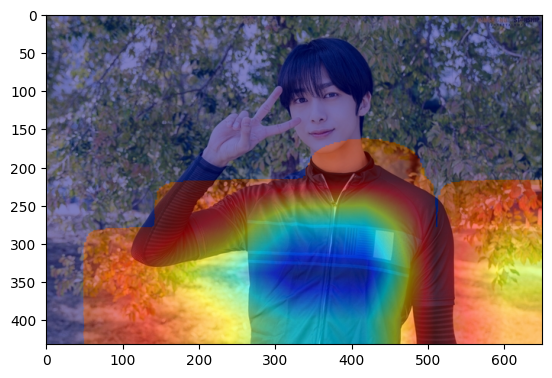

In [19]:
# CAM 마스크의 크기와 형식을 확인하고 조정합니다.
# grayscale_cam은 일반적으로 [1, H, W] 형태의 텐서입니다.
cam_mask = cam_1[0, :]  # 첫 번째 차원을 제거하여 2D 배열로 만듭니다.

# CAM 마스크를 OpenCV가 처리할 수 있는 8비트 정수 형식으로 변환합니다.
cam_mask = np.uint8(255 * cam_mask)

# 원본 이미지 데이터를 준비합니다.
raw_image = np.array(img) / 255.0

# CAM 마스크의 크기를 원본 이미지의 크기로 조정합니다.
cam_mask_resized = resize(cam_mask, (raw_image.shape[1], raw_image.shape[0]))

# CAM을 원본 이미지에 오버레이합니다.
visualization = show_cam_on_image(raw_image, cam_mask_resized, use_rgb=True)

# 결과를 표시합니다.
plt.imshow(visualization)
plt.show()